# LR示例

以下示例仅用于说明LR的工作流程，目前仅支持单机测试。

初始化mpc设备

In [1]:
from common import MPCInitializer
import secretflow as sf
mpc_init = MPCInitializer()
company, partner, coordinator = mpc_init.company, mpc_init.partner, mpc_init.coordinator
spu = mpc_init.spu

# 设置设备
devices = {
    'spu': spu,
    'company': company,
    'partner': partner,
    'coordinator': coordinator,
    'active_party': company # 验证集预测结果将揭露给active_party
}

heu_devices = (mpc_init.company_heu, mpc_init.partner_heu)

/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2025-08-28 11:45:52,379	INFO worker.py:1841 -- Started a local Ray instance.


(SPURuntime pid=98623) 2025-08-28 11:45:56.025 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime pid=98623) 2025-08-28 11:45:56.027 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


(HEUSkKeeper(heu_id=134143580238416, party=company) pid=98629) [2025-08-28 11:46:01.304] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(HEUEvaluator(heu_id=134143112857536, party=company) pid=98625) [2025-08-28 11:46:10.337] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15 [repeated 3x across cluster]
(pyu_fn pid=98634) [2025-08-28 11:52:53.220] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(pyu_fn pid=98634) [2025-08-28 11:52:53.231] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=98634) [2025-08-28 11:52:53.232] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


(pyu_fn pid=98634) 2025-08-28 11:52:53,209,209 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'cuda': 
(pyu_fn pid=98634) 2025-08-28 11:52:53,209,209 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(pyu_fn pid=98634) 2025-08-28 11:52:53,210,210 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(pyu_fn pid=98634) 2025-08-28 11:52:53,210,210 WARNING [xla_bridge.py:_suggest_missing_backends:901] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(SPURuntime(device_id=None, party=coordinator) pid=98623) 2025-08-28 11:52:53.560 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 15
(pyu_fn pid=98630) Directory '../partner_model' created or already exists.
(pyu_fn pid=98634) Directory '../company_model' created or already exists.


双方读取数据集。数据集为csv格式，应满足第一列为id或键值。其他列为数值型特征。标签列的列标题为'y'。

将键值和特征分开读取。

In [2]:
import pandas as pd
import os
import numpy as np
project_dir = os.path.dirname(os.path.abspath(''))

def read_dataset(path: str):
    data = pd.read_csv(path)
    keys = data.iloc[:, 0].astype(str).tolist()
    private_features = data.iloc[:, 1:].to_numpy(dtype=np.float32)
    header = data.columns.tolist()
    return (keys, private_features,None), header
company_data, company_header = company(read_dataset,num_returns=2)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_host.csv'))
partner_data, partner_header = partner(read_dataset,num_returns=2)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_guest.csv'))
company_header = sf.reveal(company_header)
partner_header = sf.reveal(partner_header)
#输出交集的列标题
header = company_header[1:] + partner_header[1:]
#记录标签列的索引
y_col = header.index('y')

执行PSI

求交后得到交集共享分片，分别由company和partner持有。原本company数据的特征在share的左侧，partner数据的特征在右侧。

In [3]:
from PSI import private_set_intersection
company_share, partner_share, bucket_labels = private_set_intersection(company_data, partner_data,heu_devices)
company_share.device(np.savetxt)('../company_share.csv',company_share, delimiter=',')
partner_share.device(np.savetxt)('../partner_share.csv',partner_share, delimiter=',')

Computing masked company cipher
Computing masked partner cipher
Computing company shares
Computing partner shares


划分训练集和测试集

In [4]:
from secretflow.data.split import train_test_split
from secretflow.data.ndarray import load
shares = load({company: company_share, partner: partner_share})
train_shares, test_shares = train_test_split(shares,test_size=0.2)
def split_X_y(share):
    X = np.delete(share, y_col, axis=1)
    y = share[:, y_col].reshape(-1, 1)
    return X, y

def share2spu(company_share, partner_share):
    company_share = company_share.to(spu)
    partner_share = partner_share.to(spu)
    return spu(lambda x, y : x + y)(company_share, partner_share)

X_train_company, y_train_company = company(split_X_y,num_returns=2)(train_shares.partitions[company])
X_train_partner, y_train_partner = partner(split_X_y,num_returns=2)(train_shares.partitions[partner])
X_train = share2spu(X_train_company, X_train_partner)
y_train = company(lambda x, y : x + y)(y_train_company, y_train_partner.to(devices['active_party']))

X_test_company, y_test_company = company(split_X_y,num_returns=2)(test_shares.partitions[company])
X_test_partner, y_test_partner = partner(split_X_y,num_returns=2)(test_shares.partitions[partner])
X_test = share2spu(X_test_company, X_test_partner)
y_test = company(lambda x, y : x + y)(y_test_company, y_test_partner.to(devices['active_party']))


训练指定的轮次

100%|██████████| 8/8 [00:00<00:00, 114.99it/s]


Epoch 1


3it [00:00,  5.23it/s]

Iteration 0, Accuracy: 1.0000


8it [00:01,  7.38it/s]


Epoch 2


6it [00:00, 13.21it/s]

Iteration 10, Accuracy: 1.0000


8it [00:00, 13.62it/s]


Epoch 3


8it [00:00, 13.64it/s]


Iteration 20, Accuracy: 1.0000
Epoch 4


8it [00:00, 12.98it/s]


Iteration 30, Accuracy: 1.0000
Epoch 5


8it [00:00, 14.94it/s]


Epoch 6


1it [00:00,  8.11it/s]

Iteration 40, Accuracy: 1.0000


8it [00:00, 14.43it/s]


Epoch 7


6it [00:00, 13.96it/s]

Iteration 50, Accuracy: 1.0000


8it [00:00, 14.21it/s]


Epoch 8


8it [00:00, 14.28it/s]


Iteration 60, Accuracy: 1.0000
Epoch 9


8it [00:00, 13.68it/s]


Iteration 70, Accuracy: 1.0000
Epoch 10


8it [00:00, 15.64it/s]


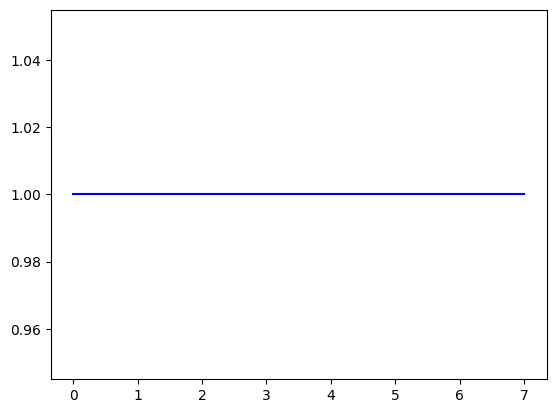

In [5]:
from LR import SSLR
import matplotlib.pyplot as plt

model = SSLR(devices, approx=False)
accs = model.fit(X_train, y_train, X_test, y_test, n_epochs=10, batch_size=1024, val_steps=10, lr=0.1)
model.save({
    'company': '../company_model',
    'partner': '../partner_model',
},ext='csv')
plt.plot(accs,label = "SSLR",color = "blue")
